In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import viz
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList, SkopeRules, IRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple_4_splits'
os.makedirs(MODELS_DIR, exist_ok=True)


# load the data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

# split the idxs
train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

# split the data
X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
X_train, y_train = X[train_idxs][:half], y[train_idxs][:half]
X_cv, y_cv = X[train_idxs][half:], y[train_idxs][half:]
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]
X_test2, y_test2 = X[test_idxs2], y[test_idxs2]
data_sizes = {
    'train': (y_train.sum(), X_train.shape[0]),
    'cv': (y_cv.sum(), X_cv.shape[0]),
    'test1': (y_test1.sum(), X_test1.shape[0]),
    'test2': (y_test2.sum(), X_test2.shape[0]),
}     
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_test1, X_test2, X_cv], [y_train, y_test1, y_test2, y_cv], ['_train', '_test1', '_test2', '_cv']):
        sens, spec, threshes = validate.sensitivity_specificity_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_cv')
        plt.title(suffix[1:])
        results['sens' + suffix] = sens
        results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return sens, spec, threshes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# fit simple models

**decision tree**

100%|██████████| 8/8 [00:00<00:00, 146.96it/s]


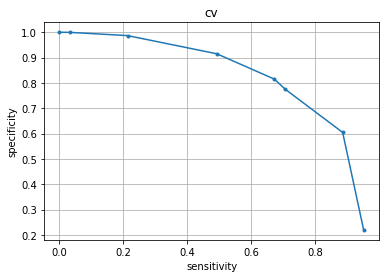

In [3]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(dt, model_name='decision_tree')

# visualize
# plt.figure(dpi=300)
# plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule list**

training bayesian_rule_list...


100%|██████████| 6/6 [00:00<00:00, 147.20it/s]


Trained RuleListClassifier for detecting IwI
IF DecrBreathSound_yes : 0.5_to_inf THEN probability of IwI: 13.9% (7.9%-21.2%)
ELSE IF GCSScore_Full_yes : 0.5_to_inf AND AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 THEN probability of IwI: 0.3% (0.1%-0.6%)
ELSE IF Hypotension_yes : 0.5_to_inf THEN probability of IwI: 33.3% (18.6%-50.0%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 THEN probability of IwI: 3.0% (1.6%-4.8%)
ELSE IF GCSScore_Full_yes : 0.5_to_inf THEN probability of IwI: 3.5% (2.1%-5.3%)
ELSE probability of IwI: 19.1% (10.8%-29.2%)



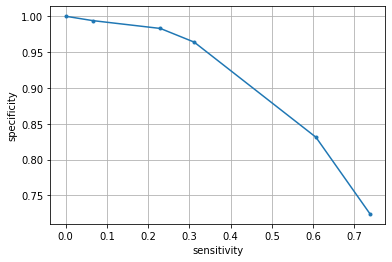

In [82]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

**rulefit**

In [ ]:
# fit a rulefit model
np.random.seed(13)
rulefit = RuleFit()
rulefit.fit(X_train, y_train, feature_names=processed_feats)

# preds = rulefit.predict(X_test)
sens, spec, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''
# print(sklearn.metrics.classification_report(y_test, preds))
rules = rulefit.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
print(rules)

**slim - sparse linear integer model**

In [ ]:
fewest_feats = data.fewest_feats
CLASS_WEIGHT = 100
n = X_train.shape[0]
lambda_reg = 10

# optionally upweight positive samples
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
X_train_small = X_train[fewest_feats]
slim = SLIM()
slim.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=lambda_reg,
         sample_weight=sample_weight)

# calculate mse on the training data
# sens, spec, threshes = predict_and_save(slim, model_name='slim')

X_test_small = X_test1[fewest_feats]
# preds = slim.predict(X_test_small)
# preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
preds_proba = slim.predict_proba(X_test_small)
print('considered ', len(fewest_feats), 'feats')
coefs = slim.model.coef_.astype(int)
intercept = slim.model.intercept_
for i in range(len(fewest_feats)):
    if coefs[i] != 0:
        print(fewest_feats[i], coefs[i])
print('intercept', intercept)

100%|██████████| 11/11 [00:00<00:00, 142.31it/s]


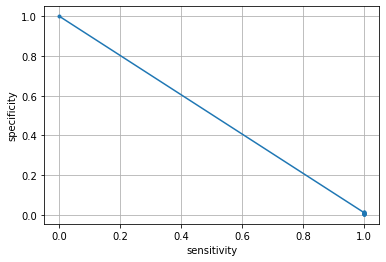

In [85]:
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test1, preds_proba[:, 1], plot=True)

**skope rules**

In [ ]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=100,
                 n_estimators=100,
                 precision_min=0.01, # per rule precision min
                 recall_min=0.1,     # per rule recall min
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
sens, spec, threshes = predict_and_save(clf, model_name='skope')

plt.show()

**greedy (CART) rule list**

/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
  0%|          | 0/10 [00:00<?, ?it/s]

1.80 -> Hypotension_yes -> 1.50 (3935) 22.81 (57)
1.50 -> AbdTrauma_or_SeatBeltSign_yes -> 0.81 (3339) 5.37 (596)
0.81 -> DecrBreathSound_yes -> 0.61 (3266) 9.59 (73)
0.61 -> ThoracicTrauma_yes -> 0.52 (2869) 1.26 (397)
0.52 -> MOI_Motorcycle/ATV/Scooter collision -> 0.47 (2741) 1.56 (128)
0.47 -> MOI_Motor vehicle collision -> 0.38 (1852) 0.67 (889)
0.38 -> MOI_Pedestrian/bicyclist struck by moving vehicle -> 0.23 (1288) 0.71 (564)
0.23 -> MOI_Bike collision/fall -> 0.17 (1148) 0.71 (140)
0.17 -> MOI_Fall from an elevation -> 0.00 (578) 0.35 (570)


100%|██████████| 10/10 [00:00<00:00, 142.63it/s]


	                                    => 1.8% risk (3992 pts)
                         if Hypotension_yes ===> 22.8% risk (57 pts)
	                                    => 1.5% risk (3935 pts)
           if AbdTrauma_or_SeatBeltSign_yes ===> 5.4% risk (596 pts)
	                                    => 0.81% risk (3339 pts)
                     if DecrBreathSound_yes ===> 9.6% risk (73 pts)
	                                    => 0.61% risk (3266 pts)
                      if ThoracicTrauma_yes ===> 1.3% risk (397 pts)
	                                    => 0.52% risk (2869 pts)
    if MOI_Motorcycle/ATV/Scooter collision ===> 1.6% risk (128 pts)
	                                    => 0.47% risk (2741 pts)
             if MOI_Motor vehicle collision ===> 0.7% risk (889 pts)
	                                    => 0.38% risk (1852 pts)
if MOI_Pedestrian/bicyclist struck by moving vehicle ===> 0.7% risk (564 pts)
	                                    => 0.23% risk (1288 pts)
               

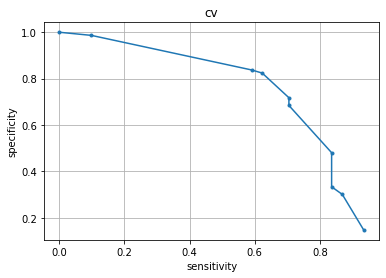

In [2]:
from imodels import GreedyRuleList
class_weight = {0: 1, 1: 1}
d = GreedyRuleList(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, verbose=True)
sens, spec, threshes = predict_and_save(d, model_name='grl')
d.print_list()

**irf - iterative Random Forest**

100%|██████████| 163/163 [00:01<00:00, 145.76it/s]


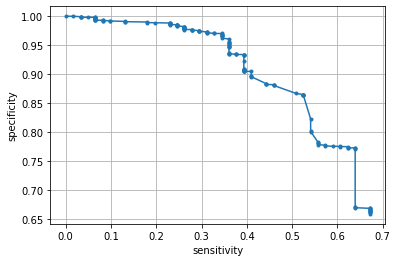

In [89]:
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(irf, model_name='irf')
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [ ]:
imps = irf.model.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

**rf**

In [ ]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

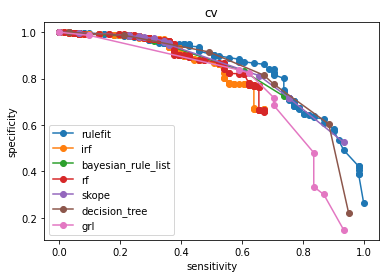

In [3]:
suffix = '_cv' # _test1, _test2, _cv
for fname in os.listdir(MODELS_DIR):
    if 'pkl' in fname:
        r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
#         print(r)
        sens = r['sens' + suffix]
        spec = r['spec' + suffix]
        plt.plot(sens, spec, 'o-', label=fname[:-4])
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.title(suffix[1:])
plt.legend()

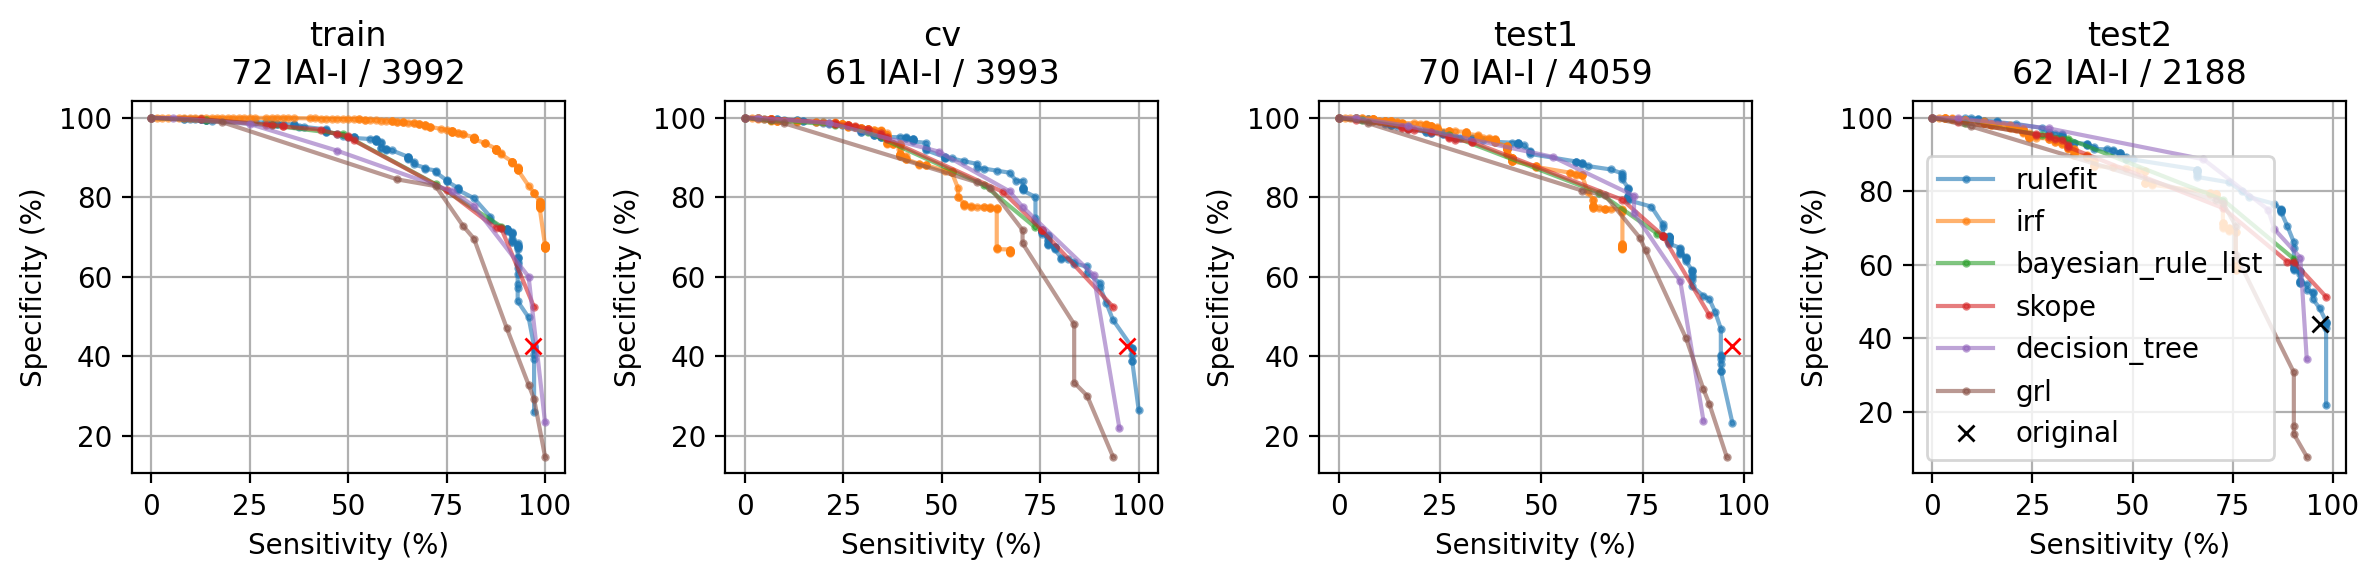

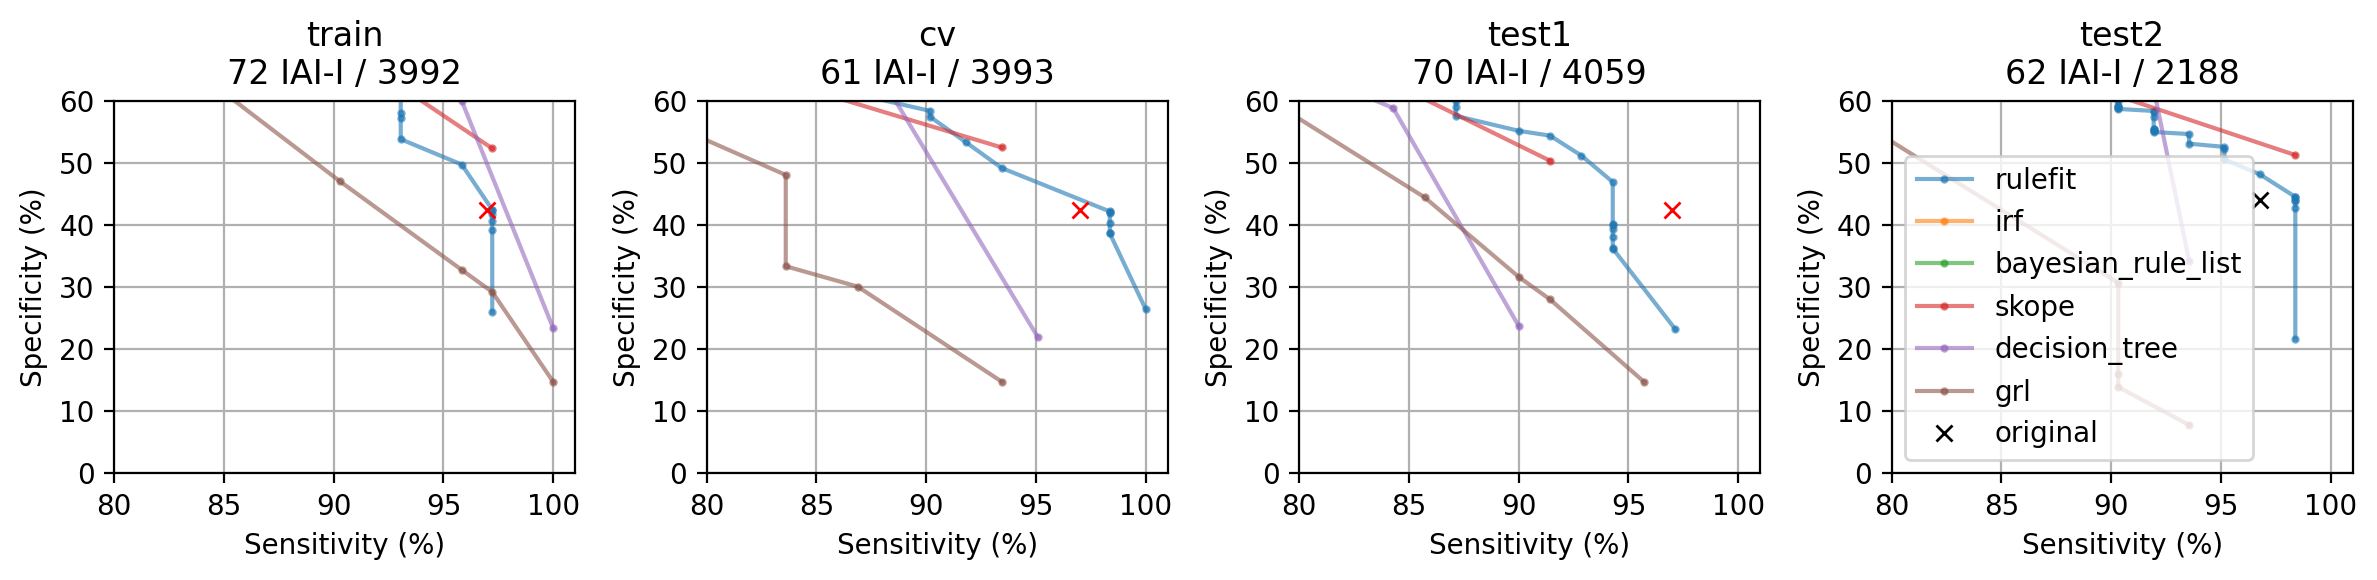

In [9]:
def plot_metrics(suffix):
    for fname in os.listdir(MODELS_DIR):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
        #         print(r)
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=2)
                plt.xlabel('Sensitivity (%)')
                plt.ylabel('Specificity (%)')
                s = suffix[1:]
                plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'x', color='black', label='original')
    else:
        plt.plot(97.0, 42.5, 'x', color='red', label='original')
    plt.grid()
#     plt.legend()



suffixes = ['_train', '_cv', '_test1', '_test2'] # _test1, _test2, _cv    
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
plt.savefig('../reports/')
plt.tight_layout()
plt.legend()
viz.savefig('metrics_4_splits')
plt.show()

plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
    plt.xlim((80, 101))
    plt.ylim((0, 60))
plt.legend()
plt.tight_layout()
plt.show()